# MDI+: Example Usages

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
sys.path.append("../../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error
import copy

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score

In [2]:
# helper variables
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=331)

## 1. Regression Example

In [3]:
# generate data from linear model: y = x1 + x2 + N(0, 1)
n = 200
p = 10
s = 2
X = np.random.normal(size=(n, p))
beta = np.concatenate((np.ones(s), np.zeros(p-s)))
y = np.matmul(X, beta) + np.random.normal(size=n)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

### 1.1 Local MDI+ (Feature Contribution) w/ Regression

In [4]:
# fit RF+
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, include_raw=False)
rf_plus_model.fit(X_train, y_train)

In [5]:
# make predictions with RF+
preds = rf_plus_model.predict(X_test)
r2_score(y_test, preds)

0.3668483947136493

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p|\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [6]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "inside")

Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.313525  0.429314  0.028768  0.027789  0.067966  0.067263  0.155701   
1    0.309911  0.512796  0.056878  0.027836  0.059945  0.043261  0.082292   
2    0.418521  0.488947  0.033151  0.039811  0.080017  0.063078  0.108197   
3    0.247684  0.506542  0.035502  0.028619  0.074017  0.074475  0.074613   
4    0.349484  0.490318  0.056752  0.031866  0.071115  0.048201  0.088609   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.259915  0.661036  0.055470  0.052382  0.056172  0.070119  0.122368   
130  0.258238  0.598808  0.073939  0.044840  0.046658  0.069065  0.105740   
131  0.265978  0.652354  0.057540  0.022938  0.057635  0.089518  0.116559   
132  0.244179  0.684709  0.052427  0.024384  0.067664  0.059018  0.096328   
133  0.206518  0.460291  0.071721  0.035733  0.066

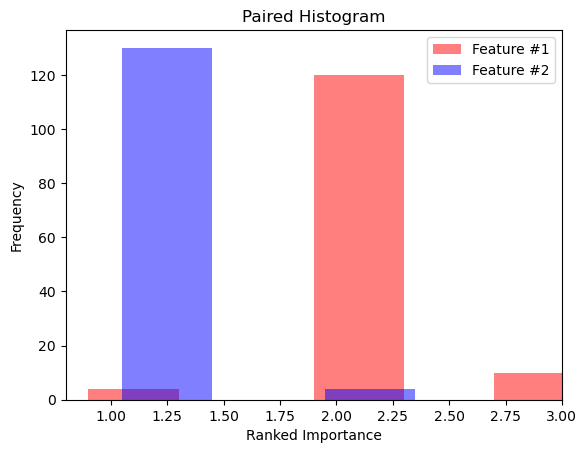

In [7]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value")
print("------------------------------------")
lfi_loo_inner = mdi_plus_scores["lfi"]
print(lfi_loo_inner)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_inner.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=|\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [8]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "outside")

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.293315  0.303037  0.026601  0.023607  0.053338  0.065393  0.140661   
1    0.276341  0.388806  0.054039  0.024643  0.044688  0.039238  0.072094   
2    0.414523  0.373033  0.031768  0.037452  0.070409  0.050665  0.081850   
3    0.189998  0.410882  0.032112  0.025356  0.069012  0.072417  0.065362   
4    0.330228  0.384954  0.055044  0.028747  0.057078  0.044156  0.077087   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.231330  0.646837  0.051185  0.049929  0.048550  0.054501  0.115786   
130  0.233872  0.580724  0.066529  0.043925  0.041054  0.052513  0.083073   
131  0.239103  0.640505  0.054896  0.020645  0.047881  0.085247  0.088703   
132  0.223563  0.657603  0.041244  0.022312  0.063429  0.046797  0.088318   
133  0.181459  0.341256  0.066493  0.033621  0.059

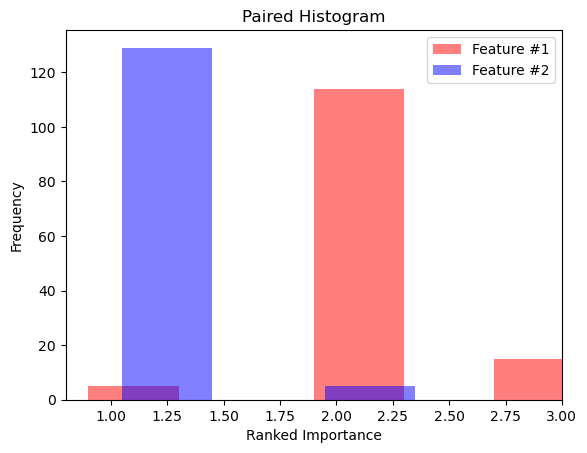

In [9]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}$

In [10]:
# get MDI+ scores (higher r^2 value = greater importance)
Xtraincopy = copy.deepcopy(X_train)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "none")
# check if X_train has been modified
print(np.array_equal(X_train, Xtraincopy))

True


In [11]:
# get MDI+ scores (higher r^2 value = greater importance)
Xtestcopy = copy.deepcopy(X_test)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True,
                                                    lfi_abs = "none", train_or_test = "test",
                                                    sample_split = None)
# check if X_test has been modified
print(np.array_equal(X_test, Xtestcopy))

True


Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
           0         1         2         3         4         5         6  \
0   0.239756  0.465646 -0.010871 -0.033241 -0.035038 -0.066534 -0.101521   
1   0.239297 -0.438911  0.018191  0.017313 -0.001677  0.003874 -0.059363   
2  -0.212988  0.000338 -0.006484 -0.001745 -0.041681  0.001250  0.081959   
3  -0.146209  0.458980  0.055258 -0.008284 -0.005985  0.053664  0.071105   
4   0.024615 -0.593175 -0.015993 -0.008293  0.008762  0.035339 -0.241235   
..       ...       ...       ...       ...       ...       ...       ...   
61 -0.166371 -0.532176  0.007755  0.006888  0.022217  0.068932 -0.000887   
62  0.021791  0.096287 -0.021711  0.013195  0.010209  0.023033  0.057885   
63  0.088404 -0.696341 -0.012986  0.012357 -0.050800 -0.065975  0.043493   
64  0.312000  0.497276  0.054026  0.005429 -0.022688 -0.055160  0.083739   
65 -0.041940  0.543191  0.014045  0.003723 -0.017327 -0.04057

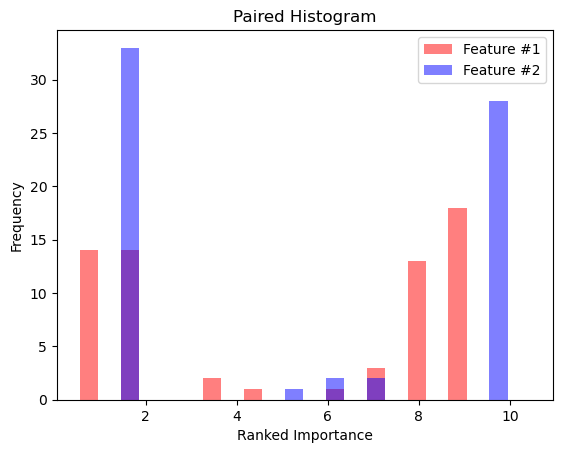

In [12]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()